In [1]:
import numpy as np
import pandas as pd
import sklearn
import sklearn.preprocessing
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
#from sklearn.model_selection import train_test_split
 
tf.logging.set_verbosity(tf.logging.INFO)
 
tf.logging.log(tf.logging.INFO, "TensorFlow version " + tf.__version__)
 
DATA_PATH = 'customers_timeseries_updated.csv'
 
df = pd.read_csv(DATA_PATH,index_col=6)
print(df.head())

#only using required columns for modelling
df = df[['client_debtor_number','fv_cost']]
# number of unique customers in the data
print("number of unique customers",len(df['client_debtor_number'].unique()))

# subsetting one customer data from the set
# 1015193,7370830
df_1015130 = df[df['client_debtor_number'] == 1015193]
#del df_1015130['client_debtor_number']

df_1015130.drop(['client_debtor_number'],1, inplace=True)



INFO:tensorflow:TensorFlow version 1.11.0
            client_debtor_number client_document_date  \
dates                                                   
10/07/2010               1015193                  NaT   
11/07/2010               1015193                  NaT   
12/07/2010               1015193                  NaT   
13/07/2010               1015193                  NaT   
14/07/2010               1015193                  NaT   

            client_unique_document_no close_date collection_comments  \
dates                                                                  
10/07/2010                        NaN        NaT                 NaN   
11/07/2010                        NaN        NaT                 NaN   
12/07/2010                        NaN        NaT                 NaN   
13/07/2010                        NaN        NaT                 NaN   
14/07/2010                        NaN        NaT                 NaN   

           converted_currency_amount disputed_final d

/Users/anusha/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/anusha/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [2]:
#weekly predictions
df_1015130['dates'] = df_1015130.index.values
df_1015130['dates'] = pd.to_datetime(df_1015130['dates'],format= '%d/%m/%Y')
#weekly data
week_data = df_1015130.set_index('dates').resample('1W').mean()

#week_data['dates'] = pd.to_datetime(week_data['dates'], errors='coerce')
#week_data['dates'] = week_data.index.values
#week_data = week_data.resample('1W')

/Users/anusha/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/anusha/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [3]:
def scale_data(df):
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
 
    df['fv_cost'] = min_max_scaler.fit_transform(df.fv_cost.values.reshape(-1, 1))
    return df
 
df = scale_data(week_data.copy())


In [4]:
df = np.array(df.fv_cost.values)

In [5]:
# Divide Lsit into chunks of length n
def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]

print (list(chunks(df,32)))

[array([0.12011934, 0.12011934, 0.12011934, 0.12011934, 0.12011934,
       0.12011934, 0.12011934, 0.12011934, 0.12011934, 0.12011934,
       0.12011934, 0.12011934, 0.12011934, 0.12011934, 0.12011934,
       0.12011934, 0.12011934, 0.12011934, 0.12011934, 0.12011934,
       0.12011934, 0.12011934, 0.12011934, 0.12011934, 0.12011934,
       0.12011934, 0.12011934, 0.12011934, 0.12011934, 0.12011934,
       0.12011934, 0.12011934]), array([0.12011934, 0.12011934, 0.12011934, 0.12011934, 0.12011934,
       0.12011934, 0.12011934, 0.12011934, 0.12011934, 0.12011934,
       0.12011934, 0.12011934, 0.12011934, 0.12011934, 0.12011934,
       0.12011934, 0.12011934, 0.12011934, 0.12011934, 0.12011934,
       0.12011934, 0.12011934, 0.12011934, 0.12011934, 0.12011934,
       0.12011934, 0.12011934, 0.12011934, 0.12011934, 0.12011934,
       0.12011934, 0.12011934]), array([0.12011934, 0.12011934, 0.12011934, 0.12011934, 0.12011934,
       0.12011934, 0.12011934, 0.12011934, 0.12011934, 0.12011

In [35]:
SEQLEN = 1  # unrolled sequence length
BATCHSIZE = 8
DATA_SEQ_LEN = len(df)
train_split = 0.8

X = df
Y = np.roll(df, -1)
 

num_data= X.shape[0]
num_train  = int(train_split * num_data)
X_train = X[0:num_train]
Y_train = Y[0:num_train]
 
Y_test = Y[num_train:]
X_test = X[num_train:]

X_train = np.reshape(X_train, [-1, SEQLEN])
Y_train = np.reshape(Y_train, [-1, SEQLEN])
 
X_test = np.reshape(X_test, [-1, SEQLEN])
Y_test = np.reshape(Y_test, [-1, SEQLEN])

#print(X_train)
 
# If not repeated data will stop after 1 epoch 
def train_dataset():
    dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
    print("dataset",dataset)
    dataset = dataset.repeat()
    #dataset = dataset.shuffle(SEQLEN) #works but i don't want to shuffle
    
    #dataset = dataset.map(lambda x: tf.py_func(convert, [x], tf.float64))
    #dataset = dataset.padded_batch(BATCHSIZE, drop_reminder = True)
    #dataset = dataset.padded_batch(BATCHSIZE,padded_shapes=-1)#tf.Dimension(None))
    #dataset = dataset.padded_batch(BATCHSIZE,padded_shapes = {'X_train':[None],'Y_train':[None]})
    #dataset = dataset.padded_batch(1, [None])
    dataset = dataset.padded_batch(1, ((None,), (None,)))
    #dataset = dataset.batch(BATCHSIZE)
    samples, labels = dataset.make_one_shot_iterator().get_next()
    return samples, labels
 
def eval_dataset():
    evaldataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))
    evaldataset = evaldataset.repeat(1)
    #evaldataset = evaldataset.repeat() #infinite loop
    evaldataset = evaldataset.batch(BATCHSIZE)
    samples, labels = evaldataset.make_one_shot_iterator().get_next()
    return samples, labels

def pred_dataset():
    evaldataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
    evaldataset = evaldataset.repeat(1)
    #evaldataset = evaldataset.repeat() #infinite loop
    evaldataset = evaldataset.batch(BATCHSIZE)
    samples, labels = evaldataset.make_one_shot_iterator().get_next()
    return samples, labels

Below function need to be modified for experimentation 

In [51]:
RNN_CELLSIZE = 80
N_LAYERS = 2
DROPOUT_PKEEP = 0.7
 
def model_rnn_fn(features, labels, mode):
    
    X = tf.expand_dims(features, axis=2)
 
    batchsize = tf.shape(X)[0]
    seqlen = tf.shape(X)[1]
     
        
    X = tf.cast(X, tf.float32)
    #cells = [tf.nn.rnn_cell.GRUCell(RNN_CELLSIZE,activation = tf.nn.leaky_relu) for _ in range(N_LAYERS)] #,activation = tf.nn.relu
     
    
    cells = [tf.contrib.rnn.LSTMBlockCell(RNN_CELLSIZE) for _ in range(N_LAYERS)]
    cells[:-1] = [tf.nn.rnn_cell.DropoutWrapper(cell, output_keep_prob=DROPOUT_PKEEP) for cell in cells[:-1]]
    # a stacked RNN cell still works like an RNN cell
    cell = tf.nn.rnn_cell.MultiRNNCell(cells, state_is_tuple=True) #False originally
 
    # X[BATCHSIZE, SEQLEN, 1], Hin[BATCHSIZE, RNN_CELLSIZE*N_LAYERS]
    Yn, H = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32) #changed dtype from example as float32 doesn't work with my python
 # dtype is changing to 32 for blockCell
    #Yn = tf.cast(Yn,)
    Yn = tf.reshape(Yn, [batchsize * seqlen, RNN_CELLSIZE])
    Yr = tf.layers.dense(Yn, 1)  # Yr [BATCHSIZE*SEQLEN, 1]
    Yr = tf.reshape(Yr, [batchsize, seqlen, 1])  # Yr [BATCHSIZE, SEQLEN, 1]
 
    Yout = Yr[:, -1, :]  # Last output Yout [BATCHSIZE, 1]
 
    loss = train_op = None
    if mode != tf.estimator.ModeKeys.PREDICT:
        labels = tf.expand_dims(labels, axis=2)
        loss = tf.losses.mean_squared_error(Yr, labels)  # la  bels[BATCHSIZE, SEQLEN, 1]
        lr = 0.001
        optimizer = tf.train.AdamOptimizer(learning_rate=lr)
 
        train_op = tf.contrib.training.create_train_op(loss, optimizer)
 
    return tf.estimator.EstimatorSpec(
        mode=mode,
        predictions={"Yout": Yout},
        loss=loss,
        train_op=train_op
    )


In [52]:
training_config = tf.estimator.RunConfig(model_dir="./outputdir")
estimator = tf.estimator.Estimator(model_fn=model_rnn_fn, config=training_config)

INFO:tensorflow:Using config: {'_model_dir': './outputdir', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1c371ad630>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [53]:
estimator.train(input_fn=train_dataset,steps=2000)

dataset <TensorSliceDataset shapes: ((1,), (1,)), types: (tf.float32, tf.float32)>
INFO:tensorflow:Calling model_fn.


TypeError: __init__() got an unexpected keyword argument 'activation'

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./outputdir/model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


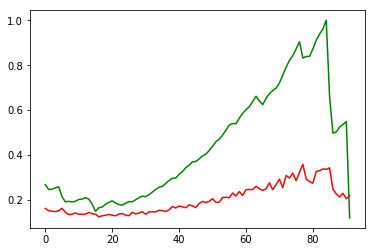

In [42]:
results = estimator.predict(eval_dataset)
 
Yout_ = [result["Yout"] for result in results]
 
actual = Y_test[:, -1]
 
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.plot(actual, label="Actual Values", color='green')
plt.plot(Yout_, label="Predicted Values", color='red', )
 
plt.show()

In [43]:
print("predicitons",Yout_)

predicitons [array([0.16219309], dtype=float32), array([0.15247624], dtype=float32), array([0.15000555], dtype=float32), array([0.14834504], dtype=float32), array([0.15219411], dtype=float32), array([0.16308863], dtype=float32), array([0.14474396], dtype=float32), array([0.1351651], dtype=float32), array([0.13640817], dtype=float32), array([0.14205426], dtype=float32), array([0.13673753], dtype=float32), array([0.13614431], dtype=float32), array([0.13691536], dtype=float32), array([0.1444853], dtype=float32), array([0.13867804], dtype=float32), array([0.13690718], dtype=float32), array([0.12507918], dtype=float32), array([0.12930779], dtype=float32), array([0.13210307], dtype=float32), array([0.13556784], dtype=float32), array([0.13225146], dtype=float32), array([0.12959957], dtype=float32), array([0.13721736], dtype=float32), array([0.13979194], dtype=float32), array([0.13263135], dtype=float32), array([0.12975827], dtype=float32), array([0.14510912], dtype=float32), array([0.13786289

In [44]:
eval1 = estimator.evaluate(eval_dataset)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-04-09-18:26:05
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./outputdir/model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-04-09-18:26:06
INFO:tensorflow:Saving dict for global step 2000: global_step = 2000, loss = 0.08988753
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: ./outputdir/model.ckpt-2000


In [45]:
print (eval1)

{'loss': 0.08988753, 'global_step': 2000}


In [46]:
# iteratively run the model on predicitons
#change training and testing datasets
# last 6 months before testset is training dataset(last 9m to 3m) and last 3m as testing dataset
trainset_x = X[-36:-12]
trainset_y = Y[-36:-12]

testset_x = X[-12:]
testset_y = Y[-12:]

#prepare the dataset and do predicitons on train and testsets
X_train = np.reshape(trainset_x, [-1, SEQLEN])
Y_train = np.reshape(trainset_y, [-1, SEQLEN])
 
X_test = np.reshape(testset_x, [-1, SEQLEN])
Y_test = np.reshape(testset_y, [-1, SEQLEN])

pred_train = estimator.predict(pred_dataset)
Yout_pred_train = [result["Yout"] for result in pred_train]
test_pred = estimator.predict(eval_dataset)
Yout_test_pred = [result["Yout"] for result in test_pred]
test_pred = Yout_test_pred[1]


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./outputdir/model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./outputdir/model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [47]:
print(len(Yout_pred_train))

24


In [48]:
# loop over 12 weeks to predict
from sklearn.metrics import mean_squared_error
n=22 #since length of Yout_pred_train is 24 22 is max number of n
Xtrain = Yout_pred_train 
Ytrain = np.roll(Yout_pred_train, -1)
Xtest = Yout_pred_train[-1]
Ytest = Yout_test_pred[1]
error_list = []
predictions = []
for i in range(1,n): #n or (max-1) of length of Xtrain
    X_train = np.reshape(Xtrain, [-1, SEQLEN])
    Y_train = np.reshape(Ytrain, [-1, SEQLEN])
    X_test = np.reshape(Xtest, [-1, SEQLEN])
    Y_test = np.reshape(Ytest, [-1, SEQLEN])   
    #train_x_cust,train_y_cust, scalar_train = prepare_training_data(pred_train, 3)
    #test_x_cust,test_y_cust,scalar_test = prepare_training_data(pred_test, 3)
    estimator.train(input_fn=train_dataset,steps=2000)
    #model_pred = lstm_model(train_x_cust,train_y_cust,3,50)
    results = estimator.predict(eval_dataset)
    Yout_ = [result["Yout"] for result in results]
    #pred_2 = model.predict(test_x_cust,batch_size=1)
    error_list.append(mean_squared_error(Y_test,Yout_))
    predictions.append(Yout_)
    print("Error at iteration ",i,mean_squared_error(Y_test,Yout_))
    #update train and test datasets
    Xtrain=np.vstack([Yout_pred_train[i:]])
    Ytrain = np.vstack([Yout_pred_train[i+1:],Xtest])
    Xtest = Ytest
    Ytest = Yout_
    #pred_test = np.vstack([pred_train[-3:],pred_2]) #input need to have 3 lags
    print ("prediction at ",i,Yout_)

dataset <TensorSliceDataset shapes: ((1,), (1,)), types: (tf.float32, tf.float32)>
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./outputdir/model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 2000 into ./outputdir/model.ckpt.
INFO:tensorflow:loss = 0.008335847, step = 2001
INFO:tensorflow:global_step/sec: 239.675
INFO:tensorflow:loss = 0.00056895515, step = 2101 (0.418 sec)
INFO:tensorflow:global_step/sec: 514.227
INFO:tensorflow:loss = 0.00016918321, step = 2201 (0.195 sec)
INFO:tensorflow:global_step/sec: 520.194
INFO:tensorflow:loss = 0.00023222168, step = 2301 (0.192 sec)
INFO:tensorflow:global_step/sec: 543.886
INFO:tensorflow:loss = 0.0015213235, step = 2401 (0.184 sec)
INFO:tensorflow:global_step/sec: 577.534
INFO:tensorflow:loss = 0.0033150748, 

INFO:tensorflow:global_step/sec: 519.519
INFO:tensorflow:loss = 1.195813e-05, step = 7901 (0.192 sec)
INFO:tensorflow:Saving checkpoints for 8000 into ./outputdir/model.ckpt.
INFO:tensorflow:Loss for final step: 0.00012145101.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./outputdir/model.ckpt-8000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Error at iteration  3 4.822701e-05
prediction at  3 [array([0.2950742], dtype=float32)]
dataset <TensorSliceDataset shapes: ((1,), (1,)), types: (tf.float32, tf.float32)>
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./outputdir/model.ckpt-8000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoin

INFO:tensorflow:global_step/sec: 529.65
INFO:tensorflow:loss = 1.3836297e-05, step = 13301 (0.189 sec)
INFO:tensorflow:global_step/sec: 527.273
INFO:tensorflow:loss = 0.00040309632, step = 13401 (0.190 sec)
INFO:tensorflow:global_step/sec: 538.857
INFO:tensorflow:loss = 4.56529e-05, step = 13501 (0.186 sec)
INFO:tensorflow:global_step/sec: 567.576
INFO:tensorflow:loss = 0.0001889892, step = 13601 (0.176 sec)
INFO:tensorflow:global_step/sec: 570.031
INFO:tensorflow:loss = 0.0013309303, step = 13701 (0.176 sec)
INFO:tensorflow:global_step/sec: 538.86
INFO:tensorflow:loss = 0.0008298904, step = 13801 (0.185 sec)
INFO:tensorflow:global_step/sec: 562.126
INFO:tensorflow:loss = 3.7858808e-06, step = 13901 (0.178 sec)
INFO:tensorflow:Saving checkpoints for 14000 into ./outputdir/model.ckpt.
INFO:tensorflow:Loss for final step: 0.000104304505.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from 

INFO:tensorflow:global_step/sec: 449.157
INFO:tensorflow:loss = 0.0008055432, step = 18701 (0.222 sec)
INFO:tensorflow:global_step/sec: 484.065
INFO:tensorflow:loss = 0.00022351074, step = 18801 (0.206 sec)
INFO:tensorflow:global_step/sec: 532.059
INFO:tensorflow:loss = 1.46694765e-05, step = 18901 (0.188 sec)
INFO:tensorflow:global_step/sec: 563
INFO:tensorflow:loss = 0.0003656066, step = 19001 (0.178 sec)
INFO:tensorflow:global_step/sec: 500.518
INFO:tensorflow:loss = 0.0013988364, step = 19101 (0.200 sec)
INFO:tensorflow:global_step/sec: 473.806
INFO:tensorflow:loss = 0.00060021266, step = 19201 (0.211 sec)
INFO:tensorflow:global_step/sec: 499.271
INFO:tensorflow:loss = 3.733371e-05, step = 19301 (0.201 sec)
INFO:tensorflow:global_step/sec: 494.406
INFO:tensorflow:loss = 0.00017766698, step = 19401 (0.203 sec)
INFO:tensorflow:global_step/sec: 496.317
INFO:tensorflow:loss = 0.0013445468, step = 19501 (0.201 sec)
INFO:tensorflow:global_step/sec: 532.865
INFO:tensorflow:loss = 0.000330

INFO:tensorflow:loss = 0.0006948923, step = 24001
INFO:tensorflow:global_step/sec: 274.526
INFO:tensorflow:loss = 0.0016409586, step = 24101 (0.365 sec)
INFO:tensorflow:global_step/sec: 539.589
INFO:tensorflow:loss = 0.00012488611, step = 24201 (0.185 sec)
INFO:tensorflow:global_step/sec: 618.969
INFO:tensorflow:loss = 0.00038784192, step = 24301 (0.162 sec)
INFO:tensorflow:global_step/sec: 522.743
INFO:tensorflow:loss = 4.4647248e-05, step = 24401 (0.192 sec)
INFO:tensorflow:global_step/sec: 501.019
INFO:tensorflow:loss = 0.0015768025, step = 24501 (0.199 sec)
INFO:tensorflow:global_step/sec: 504.33
INFO:tensorflow:loss = 0.0002481486, step = 24601 (0.198 sec)
INFO:tensorflow:global_step/sec: 523.273
INFO:tensorflow:loss = 3.993863e-05, step = 24701 (0.191 sec)
INFO:tensorflow:global_step/sec: 536.138
INFO:tensorflow:loss = 0.0003868366, step = 24801 (0.187 sec)
INFO:tensorflow:global_step/sec: 539.365
INFO:tensorflow:loss = 0.0002786183, step = 24901 (0.185 sec)
INFO:tensorflow:globa

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Error at iteration  14 8.7372944e-05
prediction at  14 [array([0.31237632], dtype=float32)]
dataset <TensorSliceDataset shapes: ((1,), (1,)), types: (tf.float32, tf.float32)>
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./outputdir/model.ckpt-30000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 30000 into ./outputdir/model.ckpt.
INFO:tensorflow:loss = 8.670176e-05, step = 30001
INFO:tensorflow:global_step/sec: 248.299
INFO:tensorflow:loss = 3.506537e-05, step = 30101 (0.403 sec)
INFO:tensorflow:global_step/sec: 530.375
INFO:tensorflow:loss = 2.987214e-06, step = 30201 (0.189 sec)
INFO:tensorflow:global_step/sec: 525.362
INFO:tensorflow:loss = 5.031772e-06, step = 30301 (0.190 sec)
I

INFO:tensorflow:loss = 0.00024400374, step = 35601 (0.182 sec)
INFO:tensorflow:global_step/sec: 548.032
INFO:tensorflow:loss = 0.0010589521, step = 35701 (0.182 sec)
INFO:tensorflow:global_step/sec: 558.866
INFO:tensorflow:loss = 0.00027488408, step = 35801 (0.179 sec)
INFO:tensorflow:global_step/sec: 553.495
INFO:tensorflow:loss = 0.0010001691, step = 35901 (0.181 sec)
INFO:tensorflow:Saving checkpoints for 36000 into ./outputdir/model.ckpt.
INFO:tensorflow:Loss for final step: 3.5373116e-05.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./outputdir/model.ckpt-36000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Error at iteration  17 0.00013581477
prediction at  17 [array([0.32042062], dtype=float32)]
dataset <TensorSliceDataset shapes: ((1,), (1,)), types: (tf.float32, tf.float32)>
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling

INFO:tensorflow:global_step/sec: 393.656
INFO:tensorflow:loss = 1.4591377e-06, step = 41001 (0.253 sec)
INFO:tensorflow:global_step/sec: 533.538
INFO:tensorflow:loss = 1.1904394e-05, step = 41101 (0.188 sec)
INFO:tensorflow:global_step/sec: 535.59
INFO:tensorflow:loss = 4.4773074e-08, step = 41201 (0.187 sec)
INFO:tensorflow:global_step/sec: 572.354
INFO:tensorflow:loss = 3.699868e-07, step = 41301 (0.174 sec)
INFO:tensorflow:global_step/sec: 587.257
INFO:tensorflow:loss = 2.8469572e-05, step = 41401 (0.170 sec)
INFO:tensorflow:global_step/sec: 596.815
INFO:tensorflow:loss = 5.29395e-06, step = 41501 (0.168 sec)
INFO:tensorflow:global_step/sec: 585.625
INFO:tensorflow:loss = 3.210038e-05, step = 41601 (0.171 sec)
INFO:tensorflow:global_step/sec: 555.401
INFO:tensorflow:loss = 3.020105e-09, step = 41701 (0.180 sec)
INFO:tensorflow:global_step/sec: 560.459
INFO:tensorflow:loss = 6.6047637e-06, step = 41801 (0.178 sec)
INFO:tensorflow:global_step/sec: 573.628
INFO:tensorflow:loss = 1.5312

In [ ]:
#plot the predictions and error
plt.plot(error_list)
plt.ylabel('error')
plt.show()

[0.293021023273468, 0.30201876163482666, 0.2950741946697235, 0.2933468520641327, 0.29481035470962524, 0.30087560415267944, 0.29946035146713257, 0.29164183139801025, 0.2977718710899353, 0.2986642122268677, 0.29763948917388916, 0.3007224202156067, 0.30302897095680237, 0.31237632036209106, 0.308904767036438, 0.3087666630744934, 0.32042062282562256, 0.32515817880630493, 0.3096643388271332, 0.3231634497642517, 0.3244439661502838]


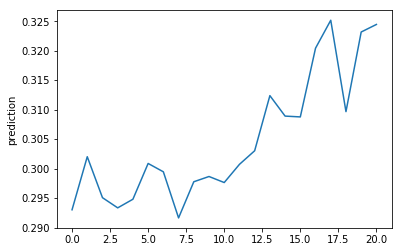

In [49]:
# predicitons
#pred_list = [l.tolist() for l in predictions]
pred_list = [arr.tolist() for sublist in predictions for arr in sublist]
pred_list = [l for sublist in pred_list for l in sublist]
print(pred_list)
plt.plot(pred_list)
plt.ylabel('prediction')
plt.show()

In [ ]:
# add predictions to actual data
test_pred_df = pd.DataFrame({'fv_cost':testset_y,'data':'testdata'})
#for j in range(len(testset_y)):
#    test_pred_df = test_pred_df.append({'fv_cost':testset_y[j],'data':'testdata'},ignore_index=True)

for i in range(len(pred_list)):
    test_pred_df = test_pred_df.append({'fv_cost':pred_list[i],'data':'predictions'},ignore_index=True)

#test_pred_df = test_pred_df.reset_index
print(test_pred_df)
plt.figure()
test_pred_df.plot()
#plt.plot(range((len(testset_y)+len(pred_list))),testset_y,c='blue')
#plt.plot(range((len(testset_y)+len(pred_list))),pred_list,c='red')
#plt.plot(test_pred_df['fv_cost'],c=test_pred_df['data'])
#plt.show()

In [ ]:
test_pred_df.groupby("data").plot()

In [ ]:
plt.plot(x=np.arange(12.5), y=testset_y)
plt.plot(x=np.arange(12.5, 30), y=pred_list)
plt.show()

In [ ]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.plot(testset_y, label="Actual Values", color='green')
plt.plot(pred_list, label="Predicted Values", color='red', )
 
plt.show()

pred_df     predictions
0      0.293021
1      0.302019
2      0.295074
3      0.293347
4      0.294810
5      0.300876
6      0.299460
7      0.291642
8      0.297772
9      0.298664
10     0.297639
11     0.300722
12     0.303029
13     0.312376
14     0.308905
15     0.308767
16     0.320421
17     0.325158
18     0.309664
19     0.323163
20     0.324444
0     457
1     458
2     459
3     460
4     461
5     462
6     463
7     464
8     465
9     466
10    467
11    468
12    469
13    470
14    471
15    472
16    473
17    474
18    475
19    476
20    477
dtype: int64
test_df        actual
0    0.120119
1    0.120119
2    0.120119
3    0.120119
4    0.120119
5    0.120119
6    0.120119
7    0.120119
8    0.120119
9    0.120119
10   0.120119
11   0.120119
12   0.120119
13   0.120119
14   0.120119
15   0.120119
16   0.120119
17   0.120119
18   0.120119
19   0.120119
20   0.120119
21   0.120119
22   0.120119
23   0.120119
24   0.120119
25   0.120119
26   0.120119
27   0.120119
28 

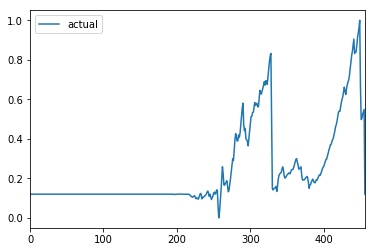

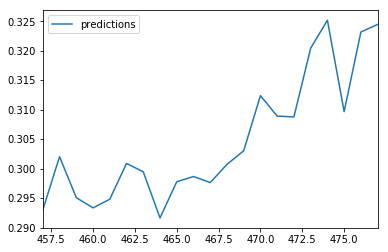

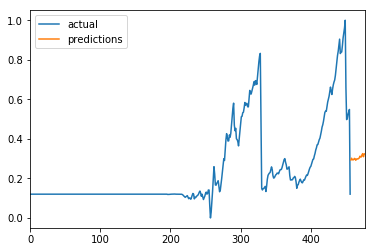

In [50]:
test_df = pd.DataFrame({'actual':Y})
pred_df = pd.DataFrame({'predictions':pred_list})
print("pred_df",pred_df)
s = pd.Series(range(len(Y),(len(Y)+len(pred_list))))
print(s)
#pred_df.set_index(s)
pred_df.index = s
print("test_df",test_df)
print("pred_df",pred_df)

test_df.plot()
pred_df.plot()

df_all = pd.merge(test_df, pred_df, how = 'outer', left_index=True, right_index=True)
df_all.plot()